# Trading Strategies powered by Machine Learning - Logistic Regression

## Logistic Regression with scikit-learn - a Simple Introduction

In [15]:
import sys
sys.path.append('../../')

In [16]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [18]:
from backtesting import Strategy

## Getting the Data

In [19]:
XAUUSD = load_data()

In [20]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [21]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


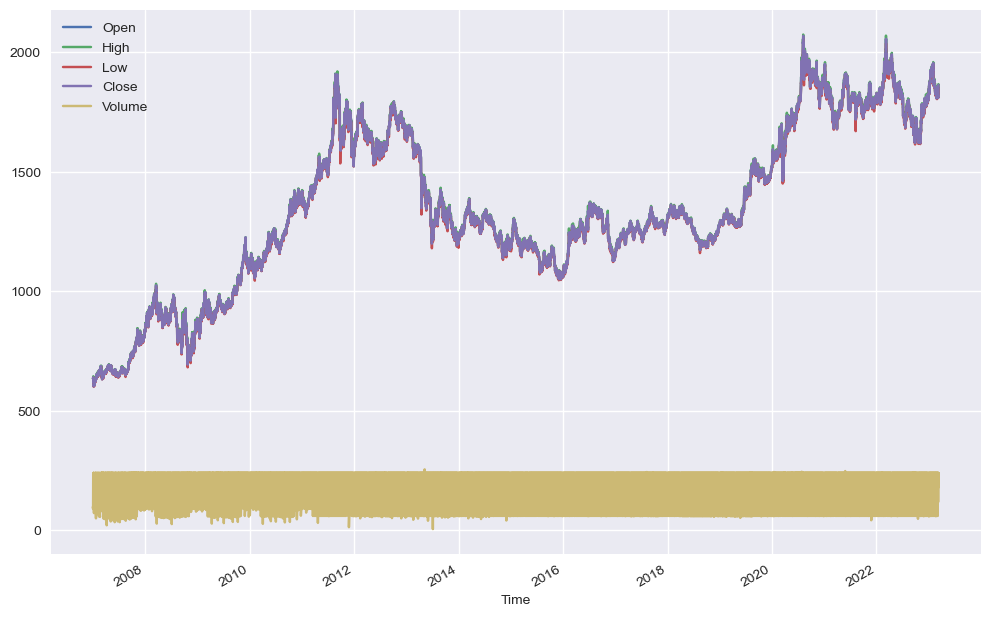

In [22]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [23]:
class Logistic_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [24]:
strategy = Logistic_Regression
account_size = 10000
folder_ML_Strategy = 'Logistic Regression'

In [25]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["return_signal"] = data["returns"].shift(-1)
        # data.dropna(inplace=True)
        data["direction"] = np.sign(data.return_signal)

        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        # data.dropna(inplace=True)
            
        data.fillna(0, inplace=True)

        lm = LogisticRegression(C=1e6, max_iter=100000, multi_class="ovr")
        lm.fit(data[cols], data['direction'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])


        self.model = lm
        self.data_train = data

    def Predict(self, lags=5):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        # data.dropna(inplace=True)
        data.fillna(0, inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data, account_size=10000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100, commission=0.0002)
        result = backtest.run()
        return result


    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)
        
        self.Predict()
        result_test = self.Backtest(self.data_test)
        

        return result_train, result_test

## TF D1

In [26]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [27]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [28]:
train , test = ml.Run()

### In-Sample Backtesting

In [29]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 00:00:00
Duration                   4747 days 00:00:00
Exposure Time [%]                   99.950642
Equity Final [$]                 10789.730896
Equity Peak [$]                  11019.577689
Return [%]                           7.897309
Buy & Hold Return [%]              138.530025
Return (Ann.) [%]                    0.473835
Volatility (Ann.) [%]                1.823458
Sharpe Ratio                         0.259855
Sortino Ratio                        0.359161
Calmar Ratio                         0.074256
Max. Drawdown [%]                   -6.381123
Avg. Drawdown [%]                   -0.342157
Max. Drawdown Duration     2644 days 00:00:00
Avg. Drawdown Duration       62 days 00:00:00
# Trades                                  681
Win Rate [%]                        56.681351
Best Trade [%]                       8.243991
Worst Trade [%]                    -13.413145
Avg. Trade [%]                    

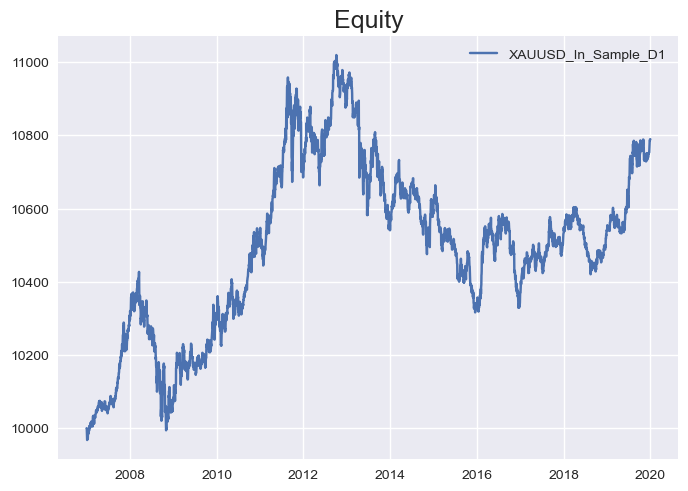

In [30]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [31]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   1164 days 00:00:00
Exposure Time [%]                   99.798184
Equity Final [$]                 10122.075335
Equity Peak [$]                  10514.544075
Return [%]                           1.220753
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                    0.309021
Volatility (Ann.) [%]                2.596656
Sharpe Ratio                         0.119007
Sortino Ratio                         0.16103
Calmar Ratio                         0.045289
Max. Drawdown [%]                   -6.823302
Avg. Drawdown [%]                    -0.69083
Max. Drawdown Duration      945 days 00:00:00
Avg. Drawdown Duration       71 days 00:00:00
# Trades                                  133
Win Rate [%]                        55.639098
Best Trade [%]                       6.720071
Worst Trade [%]                     -7.751037
Avg. Trade [%]                    

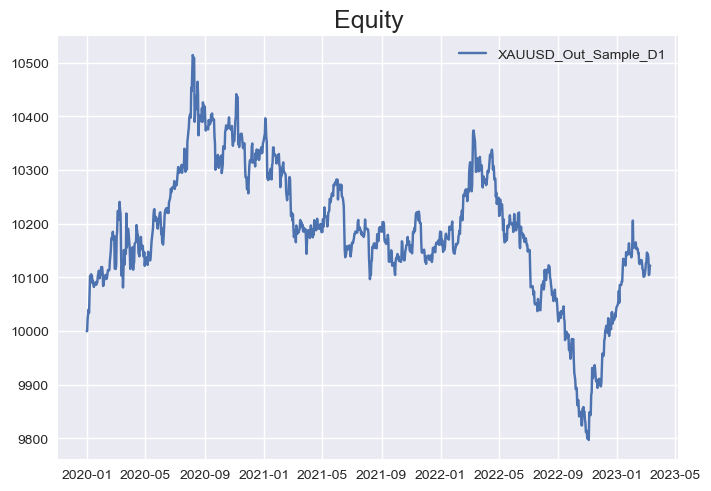

In [32]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [33]:
filename_train = f'result_{TF}_In_Sample.csv'

In [34]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [35]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [36]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [37]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [38]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [39]:
train , test = ml.Run()

### In-Sample Backtesting

In [40]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 20:00:00
Duration                   4747 days 20:00:00
Exposure Time [%]                   99.990417
Equity Final [$]                 10271.923364
Equity Peak [$]                  11669.232375
Return [%]                           2.719234
Buy & Hold Return [%]              138.697429
Return (Ann.) [%]                    0.166972
Volatility (Ann.) [%]                1.758712
Sharpe Ratio                          0.09494
Sortino Ratio                        0.131693
Calmar Ratio                         0.012523
Max. Drawdown [%]                  -13.333582
Avg. Drawdown [%]                   -0.192978
Max. Drawdown Duration     3073 days 16:00:00
Avg. Drawdown Duration       20 days 17:00:00
# Trades                                 6649
Win Rate [%]                        58.219281
Best Trade [%]                       6.707181
Worst Trade [%]                    -13.532554
Avg. Trade [%]                    

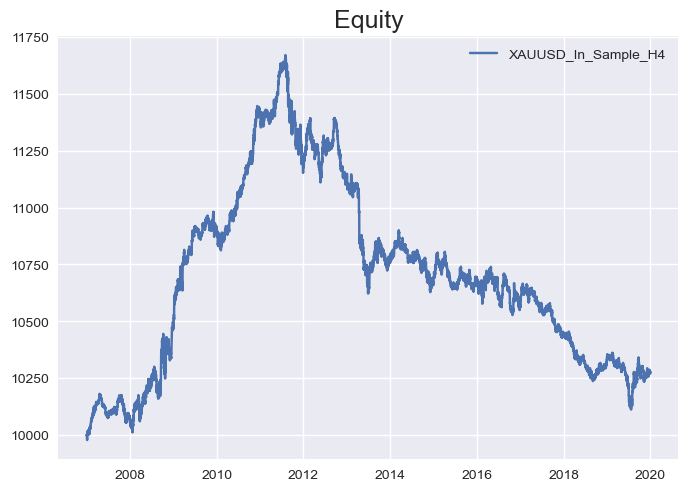

In [41]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [42]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 20:00:00
Exposure Time [%]                   99.960823
Equity Final [$]                  9383.075736
Equity Peak [$]                  10169.616353
Return [%]                          -6.169243
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                   -1.606206
Volatility (Ann.) [%]                2.690839
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -8.164639
Avg. Drawdown [%]                   -0.750304
Max. Drawdown Duration      967 days 16:00:00
Avg. Drawdown Duration       55 days 07:00:00
# Trades                                 1600
Win Rate [%]                          58.3125
Best Trade [%]                       3.284787
Worst Trade [%]                     -4.560337
Avg. Trade [%]                    

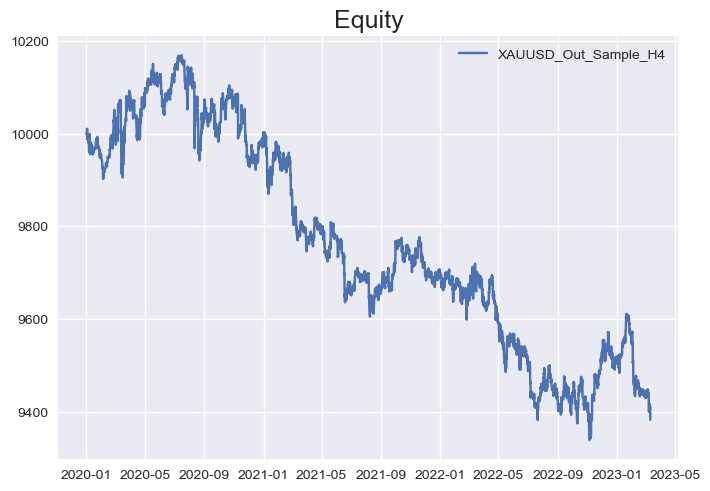

In [43]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [44]:
filename_train = f'result_{TF}_In_Sample.csv'

In [45]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [46]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [47]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [48]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [49]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [50]:
train , test = ml.Run()

### In-Sample Backtesting

In [51]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 21:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                  5338.135292
Equity Peak [$]                  10001.307653
Return [%]                         -46.618647
Buy & Hold Return [%]              138.649736
Return (Ann.) [%]                   -3.829219
Volatility (Ann.) [%]                2.062007
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -46.978756
Avg. Drawdown [%]                  -23.490813
Max. Drawdown Duration     4747 days 15:00:00
Avg. Drawdown Duration     2373 days 21:00:00
# Trades                                28163
Win Rate [%]                        60.614991
Best Trade [%]                       3.428308
Worst Trade [%]                     -9.748547
Avg. Trade [%]                    

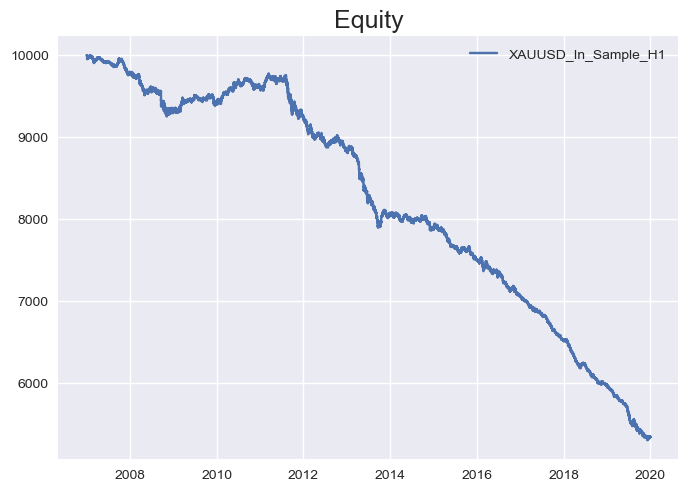

In [52]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [53]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                  8498.296787
Equity Peak [$]                  10264.364977
Return [%]                         -15.017032
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                    -4.05333
Volatility (Ann.) [%]                2.441969
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -17.943185
Avg. Drawdown [%]                   -0.494291
Max. Drawdown Duration      977 days 07:00:00
Avg. Drawdown Duration       22 days 18:00:00
# Trades                                 6643
Win Rate [%]                        60.650309
Best Trade [%]                       3.273433
Worst Trade [%]                     -5.012371
Avg. Trade [%]                    

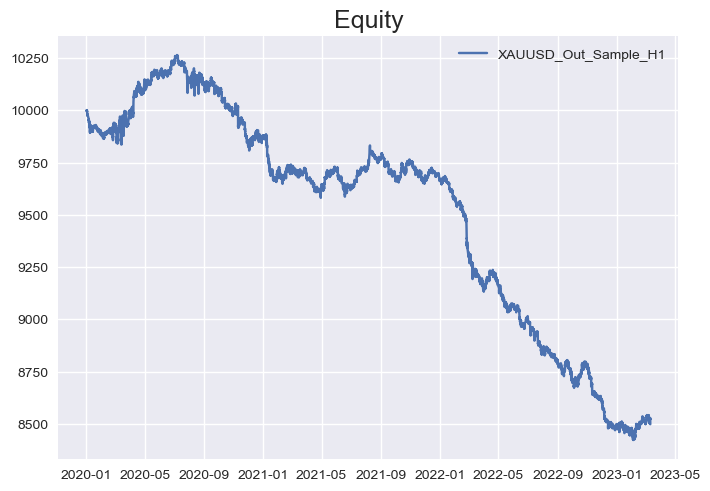

In [54]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [55]:
filename_train = f'result_{TF}_In_Sample.csv'

In [56]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [57]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [58]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [59]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [60]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [61]:
train , test = ml.Run()

### In-Sample Backtesting

In [62]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:30:00
Duration                   4747 days 21:30:00
Exposure Time [%]                    95.31618
Equity Final [$]                     10.43919
Equity Peak [$]                  10002.310992
Return [%]                         -99.895608
Buy & Hold Return [%]              138.705317
Return (Ann.) [%]                  -34.749456
Volatility (Ann.) [%]                15.79483
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -99.90593
Avg. Drawdown [%]                  -16.653313
Max. Drawdown Duration     4747 days 12:30:00
Avg. Drawdown Duration      791 days 07:15:00
# Trades                                52896
Win Rate [%]                         58.05732
Best Trade [%]                       3.207378
Worst Trade [%]                     -9.600389
Avg. Trade [%]                    

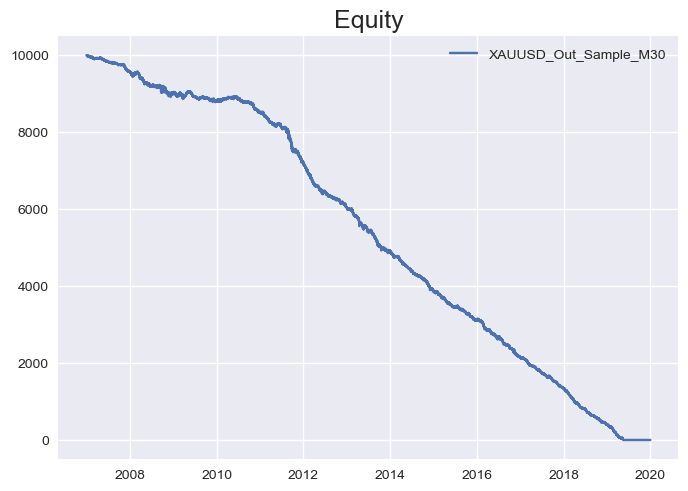

In [63]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [64]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:30:00
Exposure Time [%]                   99.994697
Equity Final [$]                  7107.577147
Equity Peak [$]                  10006.207923
Return [%]                         -28.924229
Buy & Hold Return [%]               22.670469
Return (Ann.) [%]                   -8.315802
Volatility (Ann.) [%]                2.619865
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -29.680956
Avg. Drawdown [%]                   -4.961915
Max. Drawdown Duration     1163 days 01:30:00
Avg. Drawdown Duration      193 days 22:25:00
# Trades                                13228
Win Rate [%]                         59.23042
Best Trade [%]                       1.898097
Worst Trade [%]                     -4.855696
Avg. Trade [%]                    

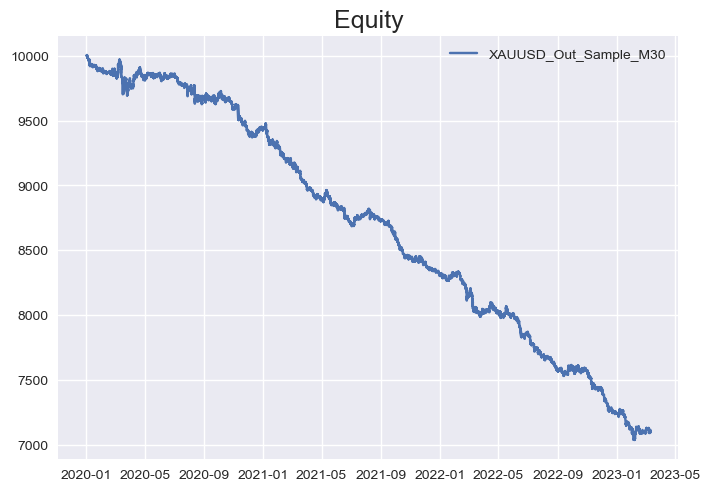

In [65]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [66]:
filename_train = f'result_{TF}_In_Sample.csv'

In [67]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [68]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [69]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [70]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [71]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [72]:
train , test = ml.Run()

### In-Sample Backtesting

In [73]:
train

Start                     2014-09-23 13:00:00
End                       2019-12-31 21:45:00
Duration                   1925 days 08:45:00
Exposure Time [%]                   99.656421
Equity Final [$]                    12.869249
Equity Peak [$]                  10001.328361
Return [%]                         -99.871308
Buy & Hold Return [%]                23.74151
Return (Ann.) [%]                  -64.036574
Volatility (Ann.) [%]               10.730374
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.879124
Avg. Drawdown [%]                  -49.964533
Max. Drawdown Duration     1925 days 01:00:00
Avg. Drawdown Duration      962 days 16:08:00
# Trades                                43789
Win Rate [%]                          51.2663
Best Trade [%]                       2.383882
Worst Trade [%]                     -4.492079
Avg. Trade [%]                    

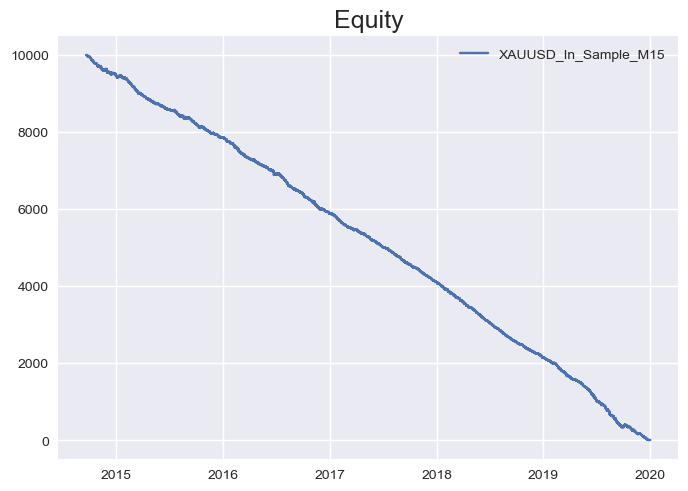

In [74]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [75]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:45:00
Duration                   1163 days 18:45:00
Exposure Time [%]                   99.997348
Equity Final [$]                  2427.484094
Equity Peak [$]                       10000.0
Return [%]                         -75.725159
Buy & Hold Return [%]               22.657555
Return (Ann.) [%]                   -30.22979
Volatility (Ann.) [%]                3.196331
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -75.786681
Avg. Drawdown [%]                  -75.786681
Max. Drawdown Duration     1163 days 18:30:00
Avg. Drawdown Duration     1163 days 18:30:00
# Trades                                26600
Win Rate [%]                        55.180451
Best Trade [%]                       2.034952
Worst Trade [%]                     -5.137612
Avg. Trade [%]                    

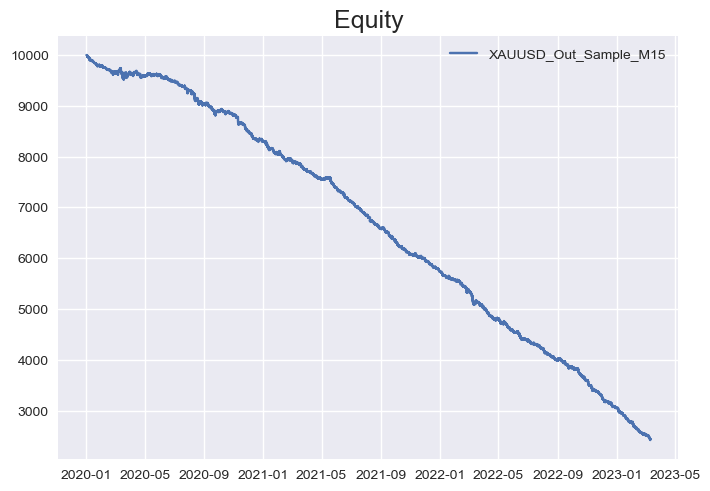

In [76]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [77]:
filename_train = f'result_{TF}_In_Sample.csv'

In [78]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [79]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [80]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [81]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [82]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [83]:
train , test = ml.Run()

### In-Sample Backtesting

In [84]:
train

Start                     2020-05-15 11:10:00
End                       2022-12-30 21:55:00
Duration                    959 days 10:45:00
Exposure Time [%]                   44.575679
Equity Final [$]                    15.515905
Equity Peak [$]                  10005.074477
Return [%]                         -99.844841
Buy & Hold Return [%]                5.144305
Return (Ann.) [%]                  -86.395206
Volatility (Ann.) [%]                7.952456
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.861511
Avg. Drawdown [%]                  -33.353144
Max. Drawdown Duration      956 days 22:55:00
Avg. Drawdown Duration      319 days 19:27:00
# Trades                                35004
Win Rate [%]                        42.226603
Best Trade [%]                       0.895932
Worst Trade [%]                     -2.426423
Avg. Trade [%]                    

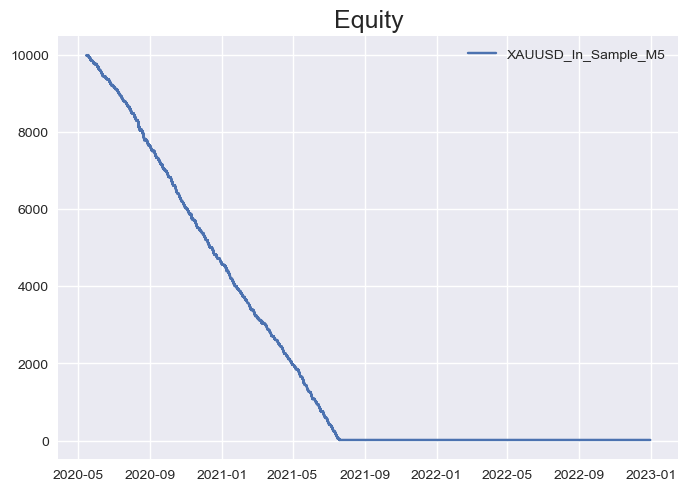

In [85]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [86]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:55:00
Exposure Time [%]                    99.98507
Equity Final [$]                   8129.06627
Equity Peak [$]                  10002.854113
Return [%]                         -18.709337
Buy & Hold Return [%]                2.045231
Return (Ann.) [%]                  -58.696382
Volatility (Ann.) [%]                1.218526
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -18.741522
Avg. Drawdown [%]                  -18.741522
Max. Drawdown Duration       66 days 18:45:00
Avg. Drawdown Duration       66 days 18:45:00
# Trades                                 5383
Win Rate [%]                        39.587591
Best Trade [%]                       0.443299
Worst Trade [%]                     -1.792416
Avg. Trade [%]                    

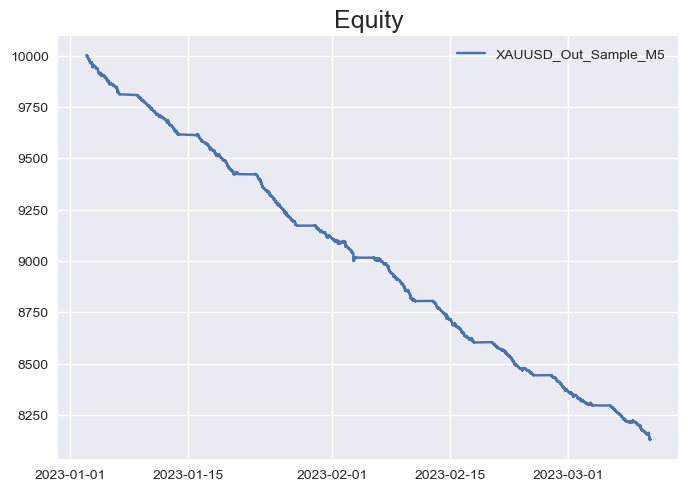

In [87]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [88]:
filename_train = f'result_{TF}_In_Sample.csv'

In [89]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [90]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [91]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [92]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [93]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [94]:
train , test = ml.Run()

### In-Sample Backtesting

In [95]:
train

Start                     2022-08-16 23:13:00
End                       2022-12-30 21:58:00
Duration                    135 days 22:45:00
Exposure Time [%]                   69.770973
Equity Final [$]                    17.153119
Equity Peak [$]                       10000.0
Return [%]                         -99.828469
Buy & Hold Return [%]                2.688945
Return (Ann.) [%]                  -99.999889
Volatility (Ann.) [%]                0.000511
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.836969
Avg. Drawdown [%]                  -99.836969
Max. Drawdown Duration      135 days 22:44:00
Avg. Drawdown Duration      135 days 22:44:00
# Trades                                30822
Win Rate [%]                        23.671404
Best Trade [%]                       1.252215
Worst Trade [%]                     -1.535729
Avg. Trade [%]                    

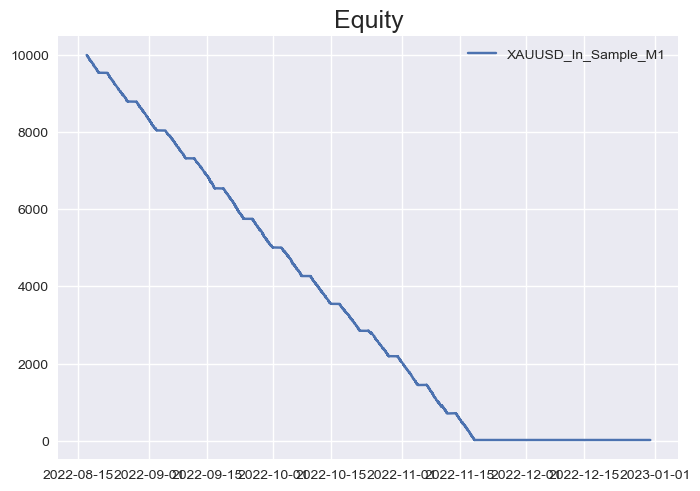

In [96]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [97]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:59:00
Exposure Time [%]                   99.997013
Equity Final [$]                  1928.940306
Equity Peak [$]                  10000.234773
Return [%]                         -80.710597
Buy & Hold Return [%]                2.050818
Return (Ann.) [%]                  -99.910872
Volatility (Ann.) [%]                0.026028
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -80.71105
Avg. Drawdown [%]                   -80.71105
Max. Drawdown Duration       66 days 18:57:00
Avg. Drawdown Duration       66 days 18:57:00
# Trades                                21711
Win Rate [%]                        20.505734
Best Trade [%]                       0.486551
Worst Trade [%]                     -0.880526
Avg. Trade [%]                    

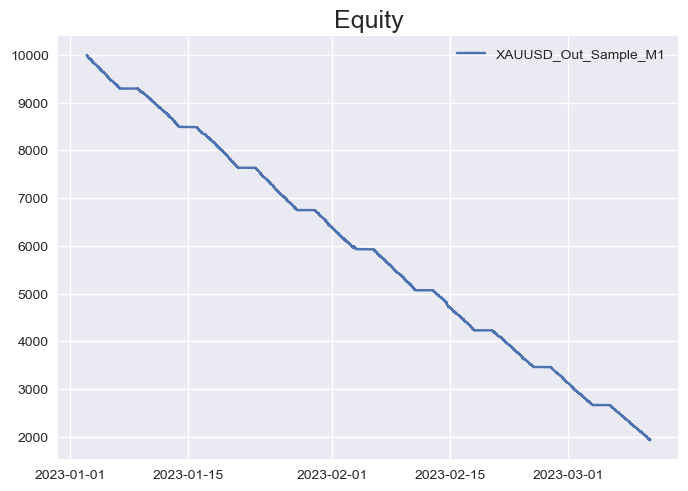

In [98]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [99]:
filename_train = f'result_{TF}_In_Sample.csv'

In [100]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')